## Implementation of Bug Algorithms Bug1




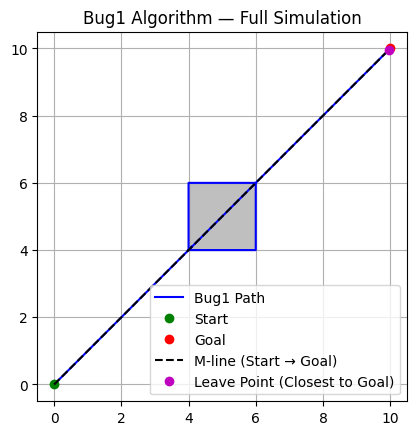

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon

# === Environment Setup ===
start = np.array([0.0, 0.0])
goal = np.array([10.0, 10.0])
step_size = 0.2

# Define a polygonal obstacle
obstacle_vertices = np.array([[4, 4], [6, 4], [6, 6], [4, 6]])
obstacle = Polygon(obstacle_vertices)

# === Helper Functions ===

def is_in_obstacle(pos):
    """Check if current position is inside the obstacle."""
    return obstacle.contains(Point(pos))

def move_towards(current, target, step):
    """Take a step from current towards target."""
    direction = target - current
    distance = np.linalg.norm(direction)
    if distance < step:
        return target
    return current + step * direction / distance

def follow_boundary(start_point):
    """Return boundary points of the obstacle starting from the closest vertex."""
    boundary_points = list(obstacle.exterior.coords)[:-1]  # Skip repeated last point
    dists = [np.linalg.norm(start_point - np.array(p)) for p in boundary_points]
    start_idx = np.argmin(dists)

    # Rotate list so we start from the closest point
    ordered_points = boundary_points[start_idx:] + boundary_points[:start_idx]
    ordered_points.append(ordered_points[0])  # Close the loop
    return [np.array(p) for p in ordered_points]

# === Bug1 Algorithm ===

def bug1(start, goal):
    path = [start.copy()]
    current = start.copy()

    while np.linalg.norm(current - goal) > 0.5:
        # Move straight toward the goal
        while not is_in_obstacle(current) and np.linalg.norm(current - goal) > 0.5:
            current = move_towards(current, goal, step_size)
            path.append(current.copy())

        if np.linalg.norm(current - goal) <= 0.5:
            break

        # Hit obstacle — follow boundary
        boundary_path = follow_boundary(current)

        # Find closest point to goal along the boundary
        closest_point = boundary_path[0]
        min_distance = np.linalg.norm(closest_point - goal)

        for p in boundary_path:
            path.append(p.copy())
            dist = np.linalg.norm(p - goal)
            if dist < min_distance:
                min_distance = dist
                closest_point = p.copy()

        # Leave obstacle at closest point
        current = closest_point.copy()
        path.append(current.copy())

    # Final move to goal
    while np.linalg.norm(current - goal) > 0.2:
        current = move_towards(current, goal, step_size)
        path.append(current.copy())

    return np.array(path)

# === Run the Bug1 Algorithm ===
path = bug1(start, goal)

# === Visualization ===
fig, ax = plt.subplots()
ax.plot(path[:, 0], path[:, 1], label='Bug1 Path', color='blue')
ax.plot(start[0], start[1], 'go', label='Start')
ax.plot(goal[0], goal[1], 'ro', label='Goal')

# M-line (start to goal)
ax.plot([start[0], goal[0]], [start[1], goal[1]], 'k--', label='M-line (Start → Goal)')

# Obstacle
polygon = plt.Polygon(obstacle_vertices, color='gray', alpha=0.5)
ax.add_patch(polygon)

# Highlight leave point
leave_point = path[np.argmin([np.linalg.norm(p - goal) for p in path])]
ax.plot(leave_point[0], leave_point[1], 'mo', label='Leave Point (Closest to Goal)')

ax.set_aspect('equal')
ax.set_title('Bug1 Algorithm — Full Simulation')
ax.legend()
plt.grid(True)
plt.show()


## Implementation of Bug Algorithms  Bug2

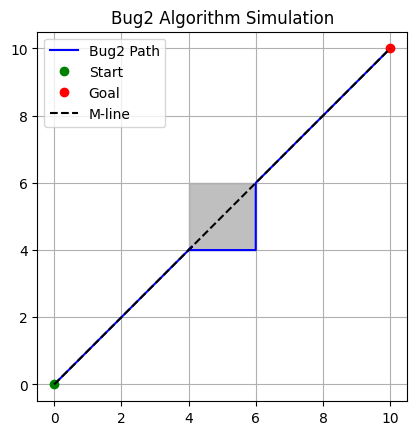

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, LineString

# Environment setup
start = np.array([0.0, 0.0])
goal = np.array([10.0, 10.0])
step_size = 0.2

# Polygonal obstacle
obstacle_vertices = np.array([[4, 4], [6, 4], [6, 6], [4, 6]])
obstacle = Polygon(obstacle_vertices)

# M-line (start to goal)
m_line = LineString([start, goal])

def is_in_obstacle(pos):
    return obstacle.contains(Point(pos))

def move_towards(current, target, step):
    direction = target - current
    distance = np.linalg.norm(direction)
    if distance < step:
        return target
    return current + step * direction / distance

def follow_boundary(start_point):
    """Simple clockwise boundary following."""
    boundary_path = []
    points = list(obstacle.exterior.coords)[:-1]
    dists = [np.linalg.norm(start_point - np.array(p)) for p in points]
    start_index = np.argmin(dists)
    n = len(points)

    for i in range(n + 1):
        idx = (start_index + i) % n
        boundary_path.append(np.array(points[idx]))

    return boundary_path

def is_on_mline(p, tol=0.1):
    return m_line.distance(Point(p)) < tol

def bug2(start, goal):
    path = [start.copy()]
    current = start.copy()

    while np.linalg.norm(current - goal) > 0.5:
        # Follow M-line toward goal
        while not is_in_obstacle(current) and np.linalg.norm(current - goal) > 0.5:
            current = move_towards(current, goal, step_size)
            path.append(current.copy())

        if np.linalg.norm(current - goal) <= 0.5:
            break

        # Obstacle encountered
        hit_point = current.copy()
        boundary_path = follow_boundary(current)

        for p in boundary_path:
            path.append(p.copy())
            if is_on_mline(p) and np.linalg.norm(p - goal) < np.linalg.norm(hit_point - goal):
                current = p.copy()
                break
        else:
            # If no closer M-line point is found (shouldn't happen), stop
            print("Bug2: Stuck — can't find exit on M-line")
            break

    # Final move to goal
    while np.linalg.norm(current - goal) > 0.2:
        current = move_towards(current, goal, step_size)
        path.append(current.copy())

    return np.array(path)

# Run Bug2
path = bug2(start, goal)

# Plotting
fig, ax = plt.subplots()
ax.plot(path[:, 0], path[:, 1], label='Bug2 Path', color='blue')
ax.plot(start[0], start[1], 'go', label='Start')
ax.plot(goal[0], goal[1], 'ro', label='Goal')

# Obstacle
polygon = plt.Polygon(obstacle_vertices, color='gray', alpha=0.5)
ax.add_patch(polygon)

# M-line
ax.plot([start[0], goal[0]], [start[1], goal[1]], 'k--', label='M-line')

ax.set_aspect('equal')
ax.set_title('Bug2 Algorithm Simulation')
ax.legend()
plt.grid(True)
plt.show()


## Implementation of Bug Algorithms  Tangent Bug

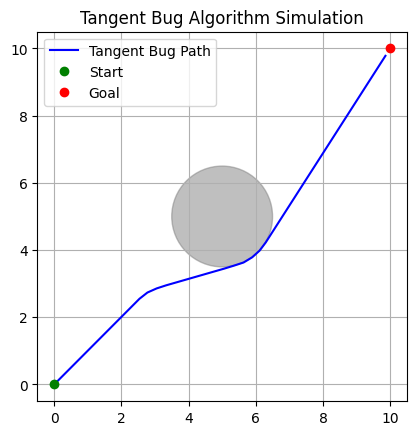

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# === Environment Setup ===
start = np.array([0.0, 0.0])
goal = np.array([10.0, 10.0])
step_size = 0.3
sensor_range = 2.0  # Max sensor range

# Define circular obstacle
obstacle_center = np.array([5.0, 5.0])
obstacle_radius = 1.5

def is_in_obstacle(pos):
    return np.linalg.norm(pos - obstacle_center) < obstacle_radius

def sense_obstacle(pos):
    """Simulates 360-degree range sensor."""
    angles = np.linspace(0, 2*np.pi, 360)
    readings = []

    for angle in angles:
        for r in np.linspace(0, sensor_range, 100):
            x = pos[0] + r * np.cos(angle)
            y = pos[1] + r * np.sin(angle)
            point = np.array([x, y])
            if is_in_obstacle(point):
                readings.append((point, r, angle))
                break
        else:
            # No obstacle within range
            readings.append((np.array([x, y]), sensor_range, angle))

    return readings

def move_towards(current, target, step):
    direction = target - current
    dist = np.linalg.norm(direction)
    if dist < step:
        return target
    return current + step * direction / dist

def tangent_bug(start, goal):
    path = [start.copy()]
    current = start.copy()

    while np.linalg.norm(current - goal) > 0.5:
        readings = sense_obstacle(current)

        # Check direct visibility to goal
        direction_to_goal = goal - current
        dist_to_goal = np.linalg.norm(direction_to_goal)
        unit_direction = direction_to_goal / dist_to_goal

        visible = True
        for d in np.linspace(0, dist_to_goal, 100):
            point = current + d * unit_direction
            if is_in_obstacle(point):
                visible = False
                break

        if visible:
            current = move_towards(current, goal, step_size)
            path.append(current.copy())
            continue

        # Not visible — scan readings and pick best tangent direction
        min_cost = float('inf')
        best_point = None
        for pt, dist, angle in readings:
            cost = dist + np.linalg.norm(pt - goal)
            if not is_in_obstacle(pt) and cost < min_cost:
                min_cost = cost
                best_point = pt

        if best_point is not None:
            current = move_towards(current, best_point, step_size)
            path.append(current.copy())
        else:
            print("Stuck: no viable path found.")
            break

    return np.array(path)

# === Run Tangent Bug Algorithm ===
path = tangent_bug(start, goal)

# === Plotting ===
fig, ax = plt.subplots()
ax.plot(path[:, 0], path[:, 1], label='Tangent Bug Path', color='blue')
ax.plot(start[0], start[1], 'go', label='Start')
ax.plot(goal[0], goal[1], 'ro', label='Goal')

# Draw circular obstacle
circle = plt.Circle(obstacle_center, obstacle_radius, color='gray', alpha=0.5)
ax.add_patch(circle)

ax.set_aspect('equal')
ax.set_title('Tangent Bug Algorithm Simulation')
ax.legend()
plt.grid(True)
plt.show()
